In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
import yfinance as yf

In [109]:
df_daily = pd.read_csv("_CL=F.csv", parse_dates=["Date"]).set_index("Date").sort_index()
df_monthly = pd.read_csv("_CPIENGSL.csv", parse_dates=["observation_date"]).rename({"observation_date": "Date"}, axis="columns").set_index("Date").sort_index()
df_monthly.index = df_monthly.index.to_period("M")

In [110]:
df_monthly = df_monthly.loc[df_daily.index[0]:]
df_monthly

,CPIENGSL
Date,
2000-08,123.800
2000-09,129.200
2000-10,129.600
2000-11,129.200
2000-12,130.100
...,...
2024-12,279.455
2025-01,282.481
2025-02,283.035


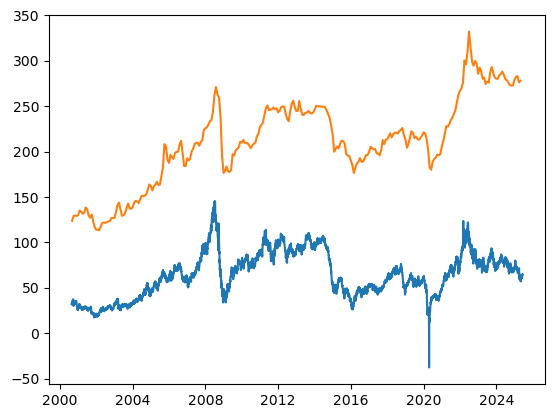

In [111]:
plt.plot(df_daily)
plt.plot(df_monthly)
plt.show()

In [112]:
"""
daily_ret   = np.log(df_daily['CL=F']).diff().dropna() * 100
monthly_mom = df_monthly['CPIENGSL'].pct_change().dropna() * 100

daily_ret = daily_ret.asfreq('B').ffill()
monthly_ts = monthly_mom.to_timestamp('M')

daily_z   = (daily_ret   - daily_ret.mean())   / daily_ret.std(ddof=0)
monthly_z = (monthly_mom - monthly_mom.mean()) / monthly_mom.std(ddof=0)
"""

daily_ret = df_daily['CL=F'].asfreq('B').ffill()
monthly_ts = df_monthly['CPIENGSL'].to_timestamp('M')

daily_z   = (daily_ret   - daily_ret.mean())   / daily_ret.std(ddof=0)
monthly_z = (monthly_ts - monthly_ts.mean()) / monthly_ts.std(ddof=0)

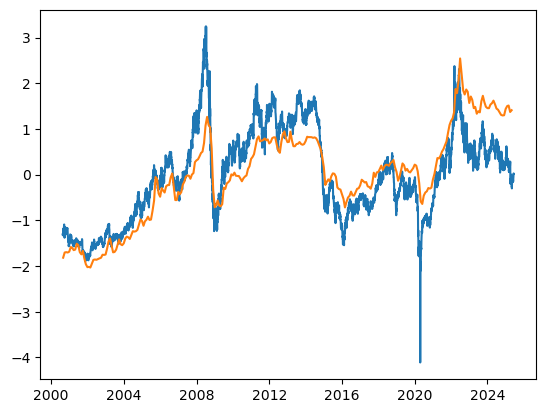

In [113]:
plt.plot(daily_z)
plt.plot(monthly_z)
plt.show()

In [114]:
monthly_z

Date
2000-08-31   -1.817237
2000-09-30   -1.704291
2000-10-31   -1.695925
2000-11-30   -1.704291
2000-12-31   -1.685467
                ...   
2024-12-31    1.438426
2025-01-31    1.501717
2025-02-28    1.513305
2025-03-31    1.371892
2025-04-30    1.410461
Freq: M, Name: CPIENGSL, Length: 297, dtype: float64

In [115]:
idx = pd.date_range(daily_z.index.min(), daily_z.index.max(), freq='B')
daily_mat   = daily_z.reindex(idx)
#monthly_mat = monthly_z.to_timestamp('M').reindex(idx)
monthly_mat = monthly_z.reindex(idx)

df_daily   = daily_mat.to_frame(name='WTI_ret')
df_monthly = monthly_mat.to_frame(name='CPI_Energy_MoM')

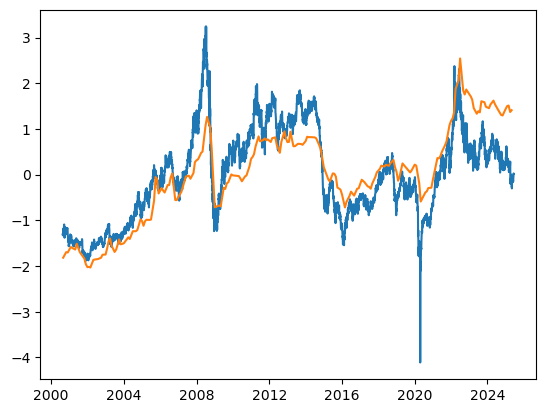

In [116]:
plt.plot(df_daily)
plt.plot(df_monthly.dropna())
plt.show()

In [117]:
df = pd.concat([df_daily, df_monthly], axis=1)
df.head(30)

,WTI_ret,CPI_Energy_MoM
2000-08-23,-1.309402,NaN
2000-08-24,-1.326288,NaN
2000-08-25,-1.309402,NaN
2000-08-28,-1.276435,NaN
2000-08-29,-1.282465,NaN
2000-08-30,-1.255127,NaN
2000-08-31,-1.267188,-1.817237
2000-09-01,-1.255931,NaN
2000-09-04,-1.255931,NaN
2000-09-05,-1.239045,NaN


In [118]:
from __future__ import annotations
import numpy as np
import pandas as pd
import calendar
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ


class DynamicFactorBizDM(DynamicFactorMQ):
    """
    Dynamic Factor Mixed-Frequency (Daily(biz) ↔ Monthly).

    Parameters
    ----------
    endog : pd.DataFrame
        インデックスは営業日だけ。最初 k_endog_daily 列が日次観測、
        残りが月次観測（値は「月末営業日」にのみ入り、他は NaN）。
    k_endog_daily : int
        日次観測の列数。
    """

    # --- (1) コンストラクタ -----------------------------------------
    def __init__(
        self,
        endog: pd.DataFrame,
        k_endog_daily: int,
        factors: int | list[int] = 1,
        factor_orders: int | list[int] = 1,
        idiosyncratic_ar1: bool = False,
        factor_multiplicative: bool = False,
        **kwargs,
    ):
        super().__init__(
            endog,
            k_endog_monthly=k_endog_daily,   # “高頻度”列として渡す
            factors=factors,
            factor_orders=factor_orders,
            idiosyncratic_ar1=idiosyncratic_ar1,
            factor_multiplicative=factor_multiplicative,
            **kwargs,
        )

    # --- (2) 低頻度（月次）集計行列 Z_t を上書き --------------------
    def _init_aggregation_matrices(self):  # noqa: N802 (元メソッド名)
        idx = self._index                                # 営業日 DatetimeIndex
        T = len(idx)

        # 状態ベクトル長 L は既定 (=31) のまま利用
        k_states = self.ssm.k_states
        L = k_states // self.factors

        kD = self.k_endog_monthly                        # 日次列数
        kM = self.k_endog - kD                           # 月次列数
        pos_M = slice(kD, self.k_endog)                  # 月次行インデックス

        # デザイン行列 Z_t (k_endog × k_states × T)
        Z_t = np.zeros((self.k_endog, k_states, T))

        # ---- 日次パート: 当日ファクターをそのまま観測 ---------------
        for r in range(kD):
            Z_t[r, 0, :] = 1.0                           # lag 0

        # ---- 月次パート: 月末営業日だけ行をセット -------------------
        #  month_groups : {Period('2024-01', 'M'): [行番号, …], …}
        month_groups = idx.to_series().groupby(idx.to_period("M"))

        for per, positions in month_groups.groups.items():
            N = len(positions)                           # 当月の営業日数
            t_last = positions[-1]                       # 月末営業日の行
            row = np.zeros(k_states)
            row[:N] = 1.0 / N                            # 1/N 平均
            Z_t[pos_M, :, t_last] = np.tile(row, (kM, 1))

        # 既存 SSModel に注入
        self.ssm["design"] = Z_t

    # ------- 便利メソッド -------------------------------------------
    def fittedvalues_full(self) -> pd.DataFrame:
        """観測欠損を補完した in-sample フィット値"""
        return self._results.predict()

    def nowcast_lowfreq(self) -> pd.Series | pd.DataFrame:
        """月次列の営業日日次ナウキャスト"""
        fit = self._results.predict()
        return fit.iloc[:, self.k_endog_monthly:]

In [123]:
df = df.iloc[-500:]

In [124]:
mod = DynamicFactorBizDM(df, k_endog_daily=1, factors=1, factor_orders=2)
res = mod.fit(disp=False)

/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['factor_multiplicative']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


In [125]:
fitted = res.predict()         # df と同じ形
yM_nowcast = fitted["CPI_Energy_MoM"]

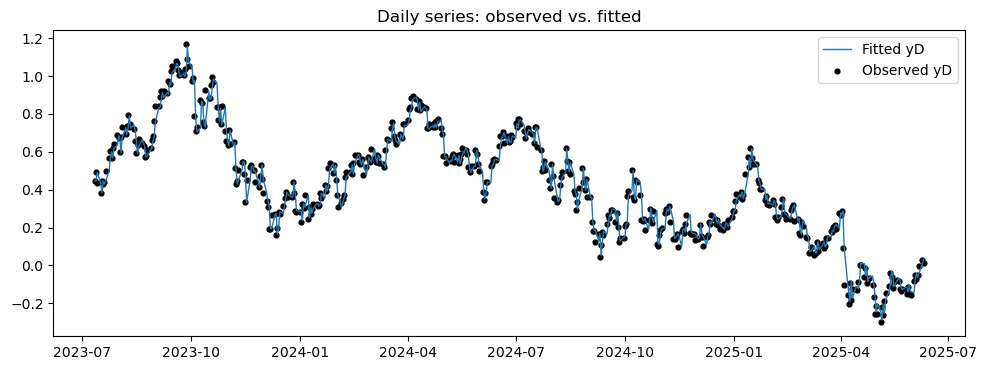

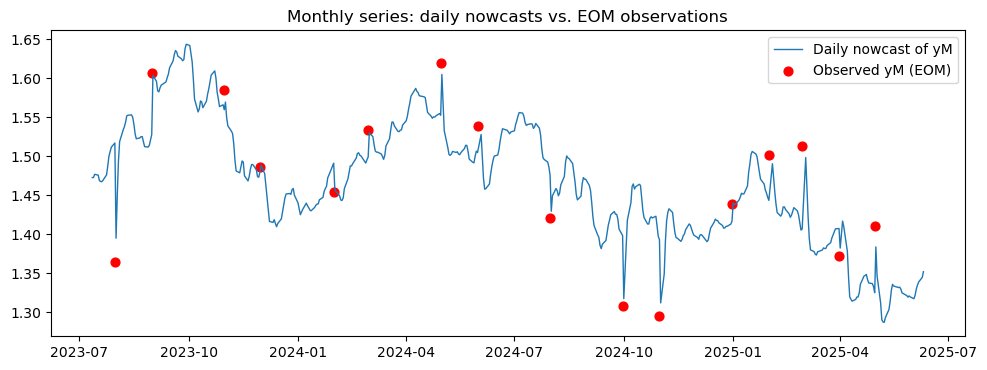


One-step-ahead forecast:
             WTI_ret  CPI_Energy_MoM
2025-06-11  0.021358         1.35704


In [126]:
plt.figure(figsize=(10, 3.8))
plt.plot(fitted["WTI_ret"], lw=1, label="Fitted yD")
plt.scatter(df.index, df["WTI_ret"], s=12, c="k", label="Observed yD")
plt.title("Daily series: observed vs. fitted"); plt.legend(); plt.tight_layout()

plt.figure(figsize=(10, 3.8))
plt.plot(yM_nowcast, lw=1, label="Daily nowcast of yM")
plt.scatter(df.index[df["CPI_Energy_MoM"].notna()],
                df.loc[df["CPI_Energy_MoM"].notna(), "CPI_Energy_MoM"],
                c="r", s=40, marker="o", label="Observed yM (EOM)")
plt.title("Monthly series: daily nowcasts vs. EOM observations")
plt.legend(); plt.tight_layout(); plt.show()

    # 7. 翌営業日の 1 ステップ先予測
print("\nOne-step-ahead forecast:")
print(res.forecast(steps=1))